### Importing relevant packages

In [1]:
import pandas as pd
import numpy as np
from autocorrect import Speller
from nltk.stem import PorterStemmer
import contractions
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer


import nltk
import string
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_colwidth', None)

### EDA (Exploratory data analysis)

In [2]:
data=pd.read_csv('train.csv')
df=data.copy()

<AxesSubplot:xlabel='Label', ylabel='count'>

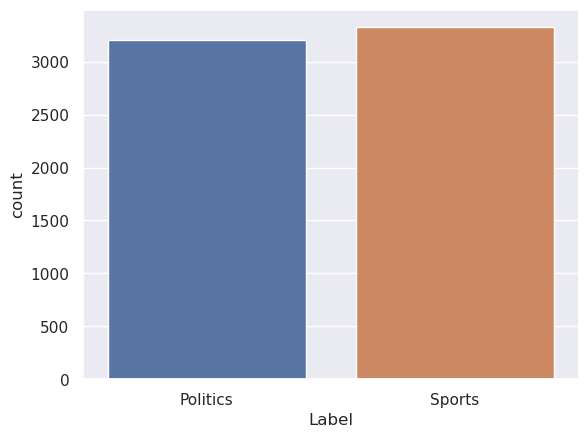

In [3]:
    sns.countplot(x = 'Label', data = df)

In [4]:
print('Dataset size:',df.shape)
print('Columns are:',df.columns)

Dataset size: (6525, 3)
Columns are: Index(['TweetId', 'Label', 'TweetText'], dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    6525 non-null   int64 
 1   Label      6525 non-null   object
 2   TweetText  6525 non-null   object
dtypes: int64(1), object(2)
memory usage: 153.1+ KB


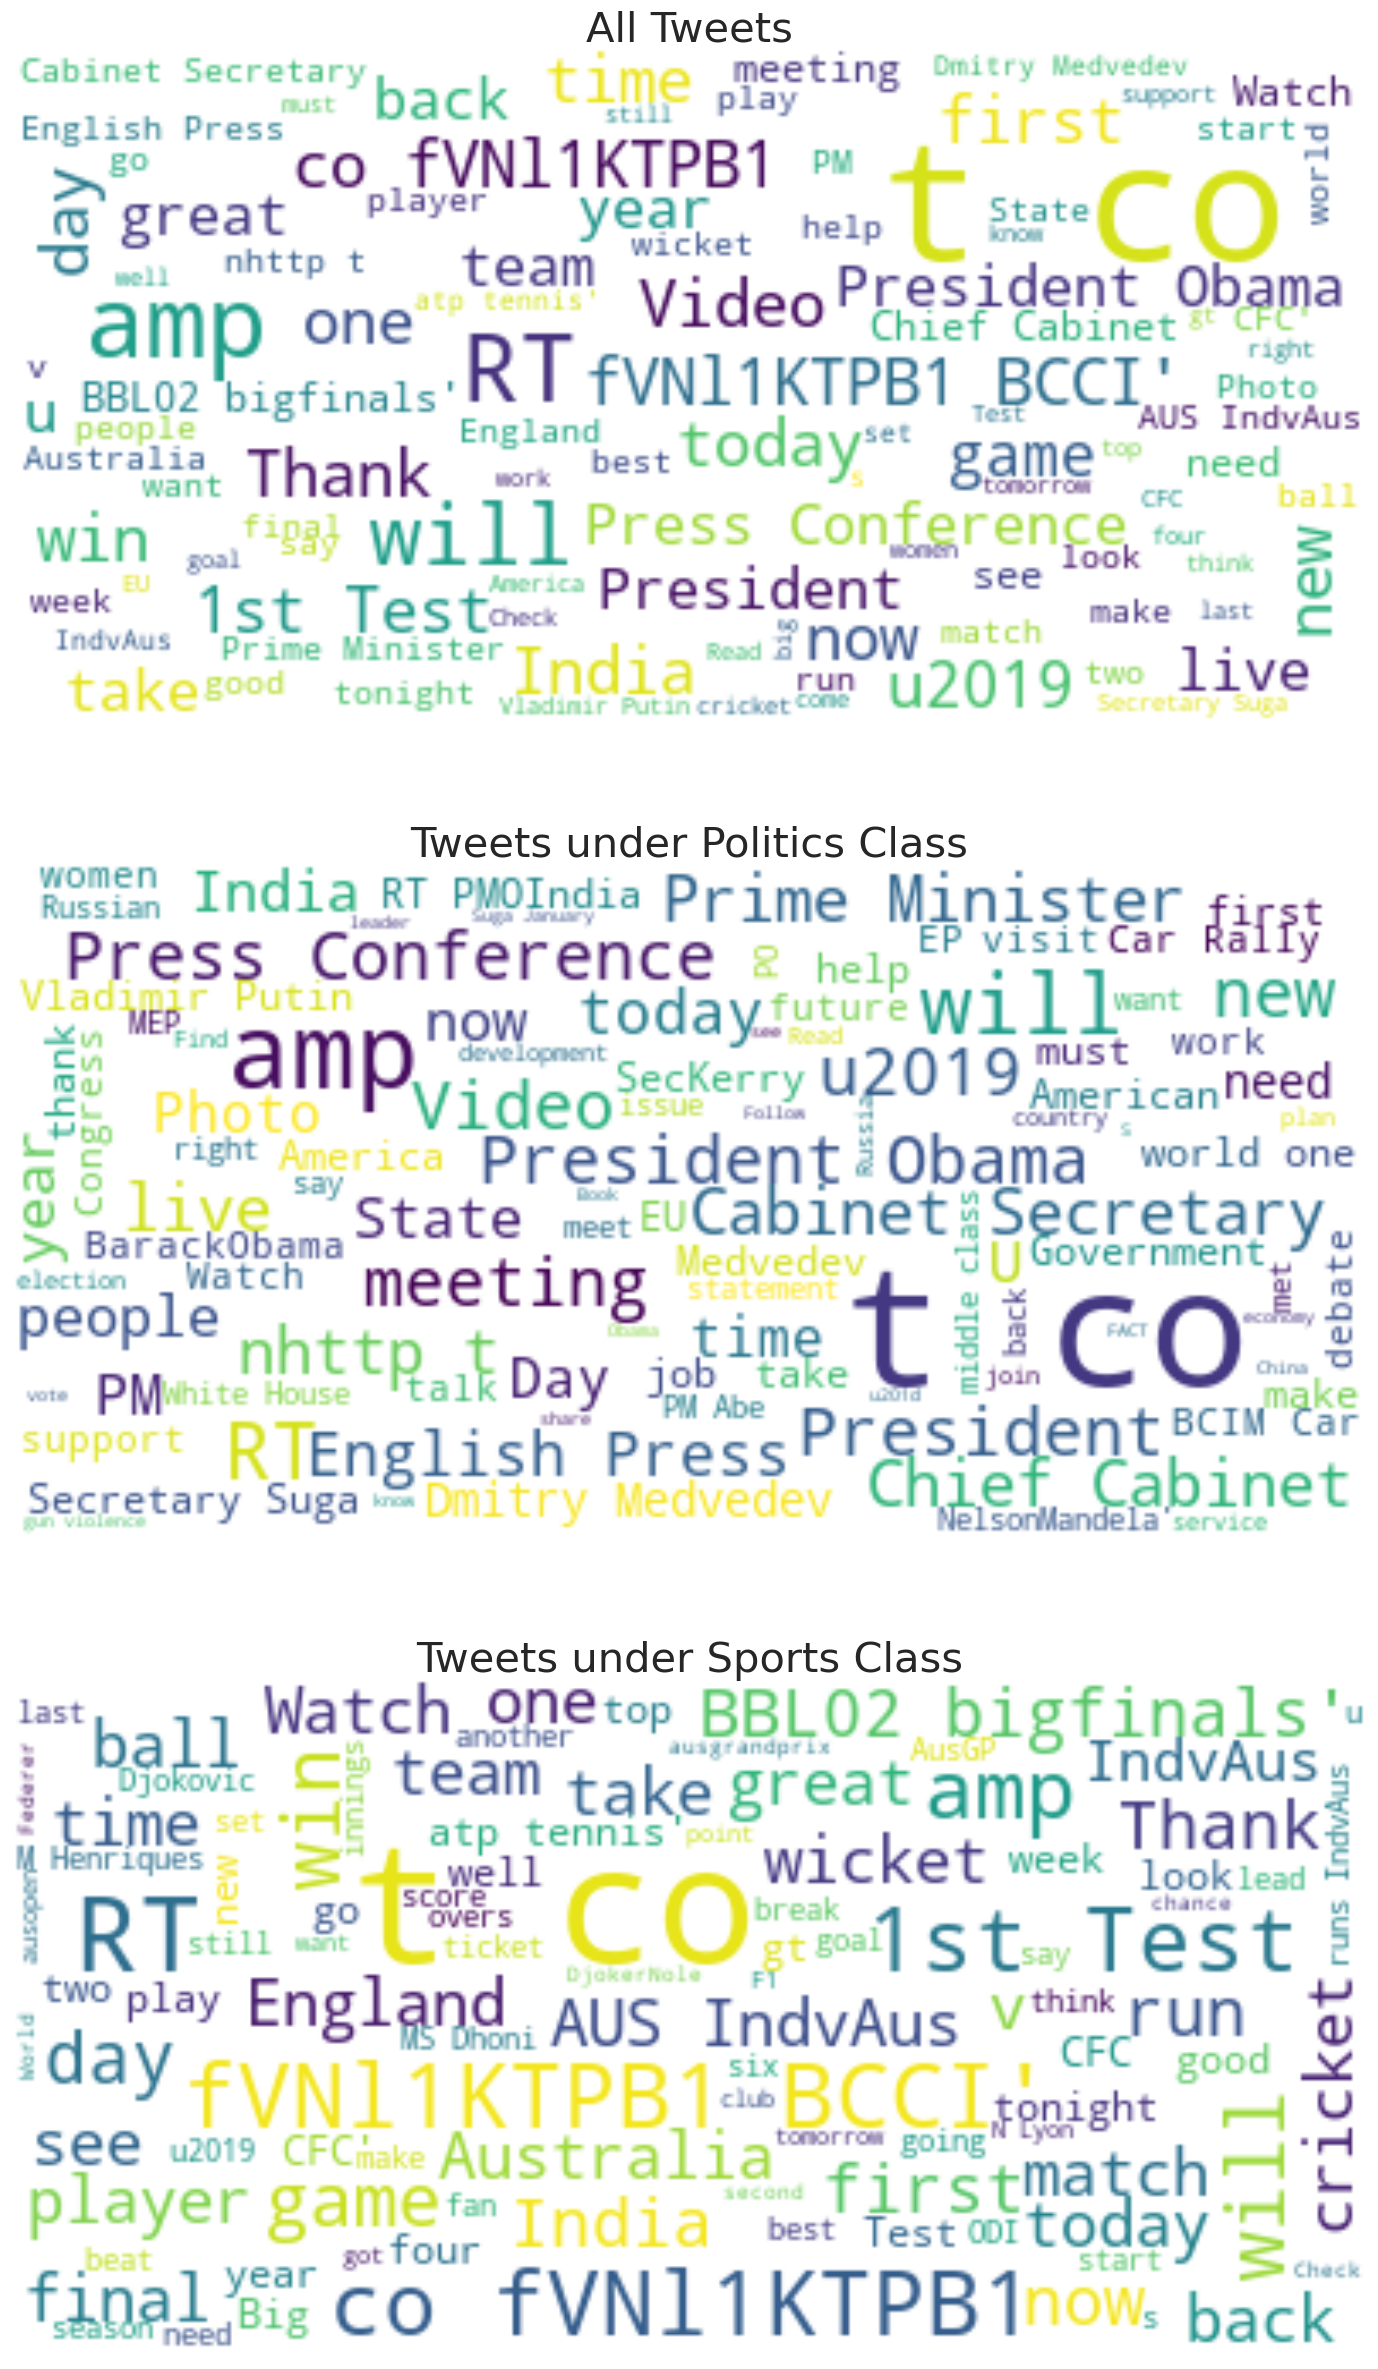

In [6]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt

# Create separate dataframes for each class label
df_politics = df[df['Label'] == 'Politics']
df_sports = df[df['Label'] == 'Sports']

# Concatenate all tweets for each class label
all_tweets = " ".join(tweet for tweet in df.TweetText)
politics_tweets = " ".join(tweet for tweet in df_politics.TweetText)
sports_tweets = " ".join(tweet for tweet in df_sports.TweetText)

# Create a figure with three subplots
fig, ax = plt.subplots(3, 1, figsize=(30, 30))

# Create word clouds for each class label
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_tweets)
wordcloud_politics = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(politics_tweets)
wordcloud_sports = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sports_tweets)

# Display the generated word clouds in the subplots
ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')

ax[1].imshow(wordcloud_politics, interpolation='bilinear')
ax[1].set_title('Tweets under Politics Class',fontsize=30)
ax[1].axis('off')

ax[2].imshow(wordcloud_sports, interpolation='bilinear')
ax[2].set_title('Tweets under Sports Class',fontsize=30)
ax[2].axis('off')

plt.show()

### Preprocessing

In [7]:
# Define custom stopword list (Best so far)
stop_words = set(stopwords.words('english'))
stop_words.update(['rt', 'amp'])
spell = Speller(lang='en')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', lambda x: x.group().replace("#", "").replace("_", " "), text)
    
    #remove accents :
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #fixing contractions 
    text=contractions.fix(text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    #remove numbers 
    text = re.sub('[0-9]+', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Break down phrases
    new_tokens = []
    for token in tokens:
        if " " in token:
            new_tokens += token.split()
        else:
            new_tokens.append(token)
            
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in new_tokens]
    
    # Join the lemmatized tokens
    text = ' '.join(tokens)
    
    return text
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Apply text cleaning to the 'TweetText' column
df['Tweetpreprocessed'] = df['TweetText'].apply(clean_text)


In [8]:
df.head()

,TweetId,Label,TweetText,Tweetpreprocessed
0,304271250237304833,Politics,"'#SecKerry: The value of the @StateDept and @USAID is measured, not in dollars, but in terms of our deepest American values.'",seckerry value statedept usaid measure dollar term deepest american value
1,304834304222064640,Politics,'@rraina1481 I fear so',rraina fear
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final between Australia and West Indies at http://t.co/lBXIIk3j',watch video highlight wwc final australia west indie
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPark ! #theymakeitlooksoeasy @ausgrandprix @ChadwickModels #CantWaitForAusGP',chelscanlan nitro circus albertpark theymakeitlooksoeasy ausgrandprix chadwickmodels cantwaitforausgp
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for the feedback :-)',cricketfox always good thing thanks feedback


### Vectorization

In [9]:
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed data
X = tfidf_vectorizer.fit_transform(df['Tweetpreprocessed'])

### Modelling

In [10]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X, df['Label'])
# Compute the accuracy on the training data
accuracy = nb.score(X, df['Label'])
print("Accuracy:", accuracy)

Accuracy: 0.9891187739463602


Best accuracy on test data : 91.4%

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X, df['Label'])
# Compute the accuracy on the training data
accuracy = rf.score(X, df['Label'])
print("Accuracy:", accuracy)

Accuracy: 1.0


In [12]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()
tree.fit(X,df['Label'])
# Compute the accuracy on the training data
accuracy = tree.score(X, df['Label'])
print("Accuracy:", accuracy)

Accuracy: 1.0


In [13]:
from sklearn.svm import SVC
svc=SVC()
svc.fit(X, df['Label'])
# Compute the accuracy on the training data
accuracy = svc.score(X, df['Label'])
print("Accuracy:", accuracy)

Accuracy: 1.0


In [14]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X, df['Label'])
# Compute the accuracy on the training data
accuracy = lr.score(X, df['Label'])
print("Accuracy:", accuracy)

Accuracy: 0.9857471264367816


In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(X, df['Label'])
# Compute the accuracy on the training data
accuracy = knn.score(X, df['Label'])
print("Accuracy:", accuracy)

/home/zine-elabidine/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.9664367816091954


In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Define the hyperparameters for each individual model
nb_params = {'alpha': 1.0}
rf_params = {'n_estimators': 100, 'max_depth': 10}
dt_params = {'max_depth': 10}
lr_params = {'C': 1.0}
svc_params = {'C': 1.0, 'kernel': 'linear'}

# Create the individual models with the recommended hyperparameters
nb = MultinomialNB(**nb_params)
rf = RandomForestClassifier(**rf_params)
dt = DecisionTreeClassifier(**dt_params)
lr = LogisticRegression(**lr_params)
svc = SVC(**svc_params)

# Create the voting classifier
clf = VotingClassifier(estimators=[('nb', nb), ('rf', rf), ('dt', dt), ('lr', lr), ('svc', svc)])

# Fit the model on the training data
clf.fit(X, df['Label'])



# Compute the accuracy on the training data
accuracy = clf.score(X, df['Label'])
print("Accuracy:", accuracy)

Accuracy: 0.9871264367816092
